#**Forest Cover Type Classification**

#Install Dependencies

In [ ]:
!pip install ucimlrepo xgboost scikit-learn matplotlib seaborn

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import xgboost as xgb


#Load Dataset from UCI

In [ ]:
covertype = fetch_ucirepo(id=31)
X = covertype.data.features
y = covertype.data.targets['Cover_Type']

In [ ]:
print(X.shape)           # Should show (581012, 54)
print(y.nunique())       # Should show 7 classes (0 to 6 if adjusted)
print(y.value_counts())  # Check class distribution

(581012, 54)
7
Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


#Preprocessing

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

#Train Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


#Evaluate Random Forest


--- Random Forest Results ---
Accuracy: 0.953804979217404
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.91      0.86      0.88       549
           4       0.95      0.78      0.86      1899
           5       0.93      0.89      0.91      3473
           6       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



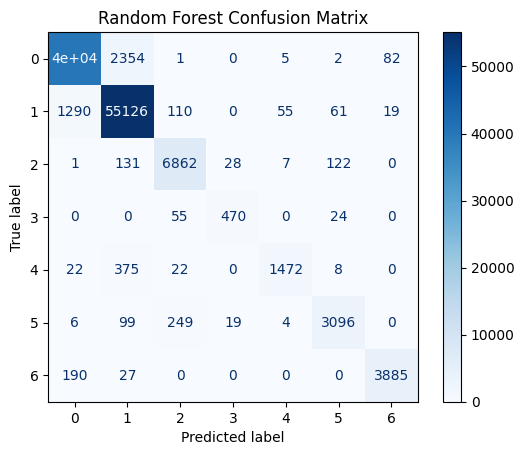

In [ ]:
print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

#Train XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#Evaluate XGBoost


--- XGBoost Results ---
Accuracy: 0.8696074972246843
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     42368
           1       0.87      0.90      0.88     56661
           2       0.89      0.91      0.90      7151
           3       0.88      0.86      0.87       549
           4       0.89      0.61      0.72      1899
           5       0.85      0.80      0.82      3473
           6       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



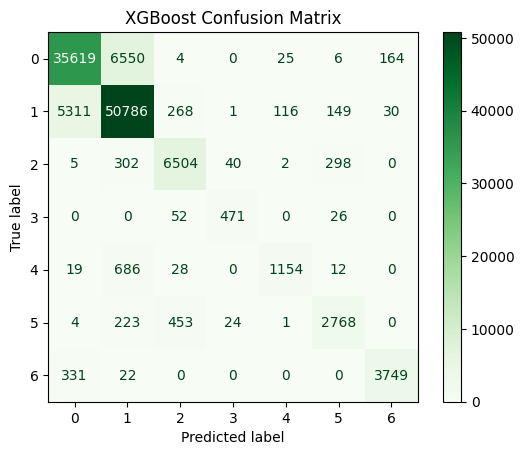

In [ ]:
print("\n--- XGBoost Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()

#Feature Importance Plot - Random Forest

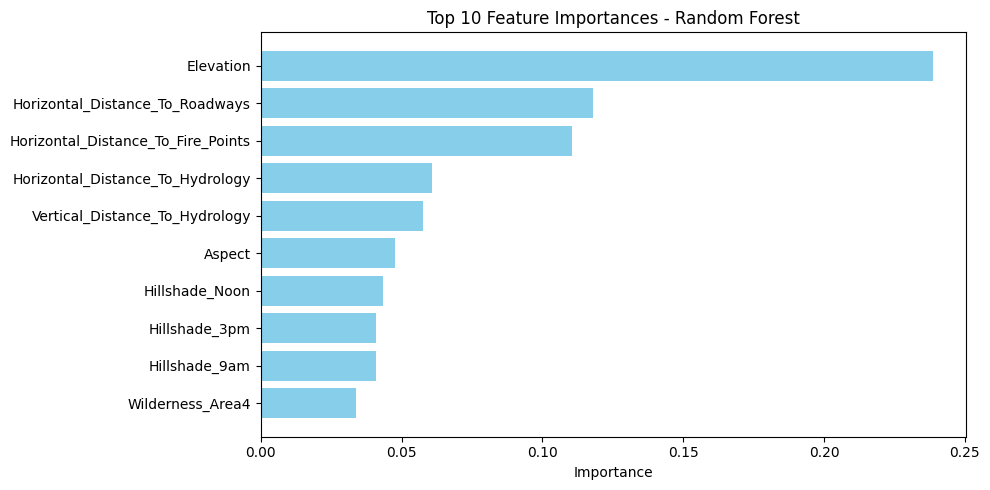

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances - Random Forest")
plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#Hyperparameter Tuning - Random Forest

In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\n--- Tuned Random Forest Results ---")
print("Best Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Tuned Random Forest Results ---
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9539082467750403
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.91      0.86      0.88       549
           4       0.95      0.78      0.86      1899
           5       0.93      0.90      0.91      3473
           6       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.95      0.95      0.95    116203



#Hyperparameter Tuning - XGBoost

In [ ]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01]
}

grid_xgb = GridSearchCV(xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42),
    xgb_params, cv=3, scoring='accuracy', n_jobs=-1)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("\n--- Tuned XGBoost Results ---")
print("Best Params:", grid_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print(classification_report(y_test, y_pred_best_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Tuned XGBoost Results ---
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.8419059748887723
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     42368
           1       0.84      0.88      0.86     56661
           2       0.85      0.89      0.87      7151
           3       0.86      0.86      0.86       549
           4       0.89      0.43      0.58      1899
           5       0.81      0.69      0.74      3473
           6       0.93      0.87      0.90      4102

    accuracy                           0.84    116203
   macro avg       0.86      0.78      0.80    116203
weighted avg       0.84      0.84      0.84    116203

